![RISE MICCAI LOGO](https://summer.rise-miccai.org/resources/images/logo.png)

# Day 4 Ensembling of Multi-Task Classification Models for Improving MRI Quality Assessment

**The Challenge**

No single model is perfect: each model has its own biases and blind spots. In real-world tasks, especially those involving noisy, imbalanced, or complex data distributions, individual models can overfit to certain patterns or make inconsistent predictions due to randomness in training (e.g., weight initialization, data splits).

**Our Solution**

Ensembling addresses this by:
1. Reducing variance: Combining multiple models smooths out their individual fluctuations.
2. Improving generalization: The ensemble tends to perform better on unseen data because it captures a broader view of the data distribution.
3. Mitigating model mistakes: Errors from one model may be compensated for by others, especially if their decision boundaries differ.


**What We'll Accomplish**

1. **Grasp ensemble fundamentals:** Understand why combining multiple models can reduce variance and improve robustness in medical‑imaging tasks.
2. **Implement voting ensembles:** Build both hard‑vote and soft‑vote aggregators over independently trained DenseNet, ResNet, and EfficientNet models.
3. **Apply bagging:** Use bootstrap sampling to train multiple DenseNet instances and aggregate their predictions by majority vote.
4. **Set up stacking:** Generate out‑of‑fold meta‑features on your validation split and train a logistic‑regression meta‑learner to optimally combine base‑model outputs.
5. **Compare performance:** Quantitatively contrast single‑model metrics against each ensemble’s results on the held‑out test set.
6. **Analyze diversity effects:** Observe how model architecture and data sampling variation contribute to ensemble gains and error correction.


## **A Reminder about the Clinical Problem**

**The Challenge:**
- Low-field MRI systems (0.064T) make healthcare more accessible but produce images with various artifacts
- Manual quality assessment is time-consuming and subjective
- Automated quality control can improve clinical workflow efficiency

**Our Solution:**
- Develop an AI system to automatically detect 7 types of image artifacts
- Use deep learning to classify artifact severity (0=none, 1=mild, 2=severe)
- Enable real-time quality feedback during MRI acquisition

## **Dataset Overview: LISA (Low-field Image quality Assessment)**

**Technical Specifications:**
- **Field Strength**: 0.064T (Hyperfine SWOOP system)
- **Sequence**: Spin Echo (TR=1.5s, TE=5ms, TI=400ms)
- **Sites**: Multi-center data from Uganda, South Africa, USA
- **Format**: NIfTI (.nii.gz) with CSV quality labels

**Quality Categories We'll Assess:**
1. **Noise** - Random signal variations
2. **Zipper** - Radiofrequency interference artifacts
3. **Positioning** - Patient positioning issues
4. **Banding** - Intensity variation artifacts
5. **Motion** - Patient movement during scan
6. **Contrast** - Image contrast problems
7. **Distortion** - Geometric distortions


---


In [ ]:
!wget https://mbzuaiac-my.sharepoint.com/:u:/g/personal/shahad_hardan_mbzuai_ac_ae/EYXD4QbhEk1CnKRQSS481MoBdocMNvV6gWNtb79qKUGIqA?download=1 -O LISA_Task_1.zip

!unzip LISA_Task_1.zip -d ./LISA_Task_1

In [ ]:
!pip install monai nibabel matplotlib pandas numpy scikit-learn torch torchvision

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Medical imaging
import nibabel as nib
import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityRanged, RandRotated, RandFlipd, RandZoomd,
    RandGaussianNoised, RandAdjustContrastd, Resized, ToTensord,
)

from monai.transforms import Transform, RandRotated
from monai.data import DataLoader, Dataset
import monai.networks.nets as nets

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Sampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode


def set_seed(seed: int) -> None:
    print(f"Set a random seed as {seed}.")

    os.environ["PYTHONHASHSEED"] = str(seed)  # os
    random.seed(seed)  # random
    np.random.seed(seed)  # numpy
    monai.utils.set_determinism(seed)  # monai

    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set random seed for reproducibility
set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Set a random seed as 42.


## Data Loading and Training Setup

#### **A Reminder about the Data**


**Quality Score Interpretation:**
- **Score 0**: No visible artifact - image is clinically acceptable
- **Score 1**: Mild artifact - noticeable but doesn't significantly impact diagnosis
- **Score 2**: Severe artifact - significantly impairs ability to distinguish neural structures


**Understanding MRI Orientations:**
- **Axial (Transverse)**: Horizontal slices, like looking down at the top of the head
- **Coronal**: Vertical slices from front to back, like a face-on view
- **Sagittal**: Vertical slices from side to side, like a profile view

**Why Analyze by Orientation?**
- Different orientations may be more susceptible to specific artifacts
- Motion artifacts might affect orientations differently based on scan order
- Some anatomical structures are better visualized in certain orientations

**Our Preprocessing Pipeline:**
1. **Load NIfTI files** with proper medical image handling
2. **Standardize orientation** to RAS coordinate system
3. **Resample spacing** to consistent voxel sizes
4. **Normalize intensities** to [0,1] range
5. **Resize volumes** to manageable dimensions for GPU memory
6. **Convert to tensors** for PyTorch compatibility

**Our Solution: Patient-Level Splitting**
- Split by **patient ID**, not by individual images
- Ensures no patient appears in both training and test sets
- Provides realistic performance estimates for new patients

**Split Strategy:**
- **70% Training**: For model learning and parameter updates
- **15% Validation**: For hyperparameter tuning and early stopping
- **15% Testing**: For final, unbiased performance evaluation

In [5]:
# Define paths
data_dir = Path('./LISA_Task_1')
csv_path = data_dir / 'LISA_LF_QC_2025.csv'

# Load the QC ratings CSV
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"First few rows:")
print(df.head())

print(f"Columns: {df.columns.tolist()}")
print(f"Data types:")
print(df.dtypes)

Dataset shape: (532, 8)
First few rows:
                  filename  Noise  Zipper  Positioning  Banding  Motion  \
0  LISA_0001_LF_axi.nii.gz      0       0            0        0       0   
1  LISA_0001_LF_cor.nii.gz      0       0            0        0       0   
2  LISA_0001_LF_sag.nii.gz      0       0            0        0       0   
3  LISA_0002_LF_axi.nii.gz      0       0            0        0       0   
4  LISA_0002_LF_cor.nii.gz      0       0            0        0       0   

   Contrast  Distortion  
0         0           0  
1         0           0  
2         0           1  
3         0           0  
4         0           2  
Columns: ['filename', 'Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']
Data types:
filename       object
Noise           int64
Zipper          int64
Positioning     int64
Banding         int64
Motion          int64
Contrast        int64
Distortion      int64
dtype: object


Patients with all 3 orientations: 144
Patients with partial orientations: 100
First few patients with all orientations: ['LISA_0001', 'LISA_0002', 'LISA_0003', 'LISA_0004', 'LISA_0005']
Patient: LISA_0001
Available orientations for LISA_0001: ['axi', 'cor', 'sag']


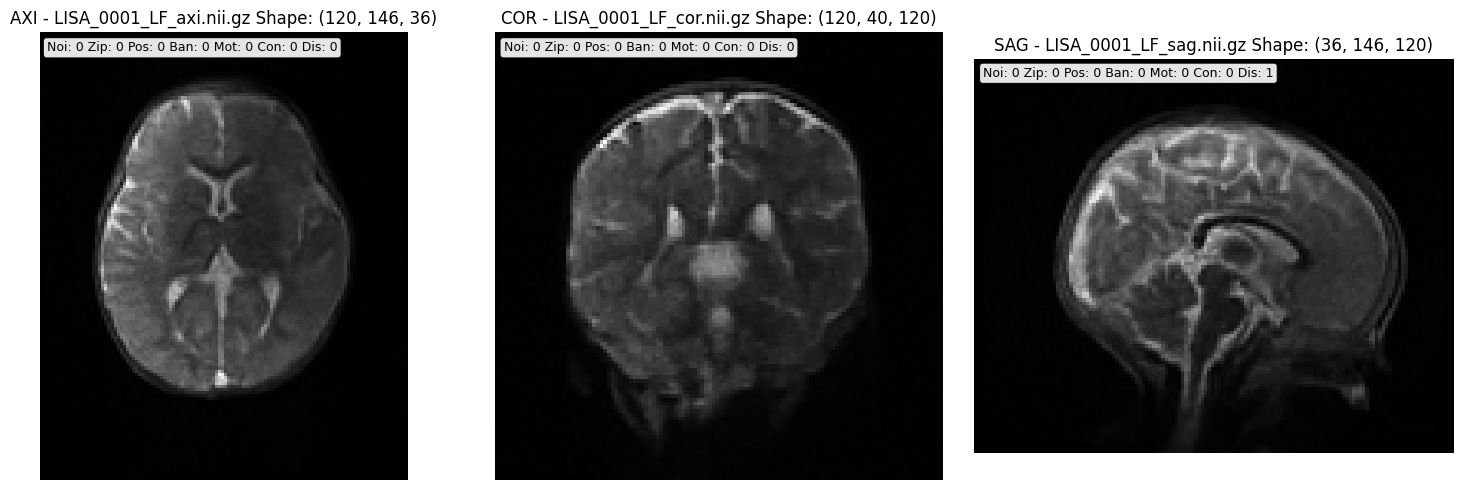

Patient: LISA_0002
Available orientations for LISA_0002: ['axi', 'cor', 'sag']


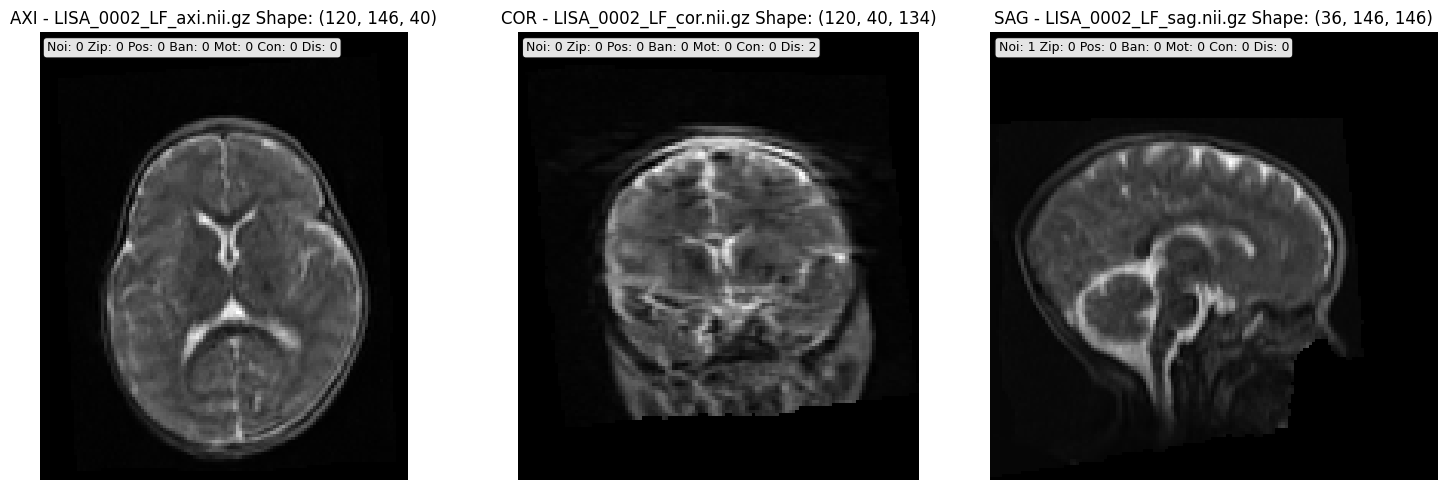

Patient: LISA_0003
Available orientations for LISA_0003: ['axi', 'cor', 'sag']


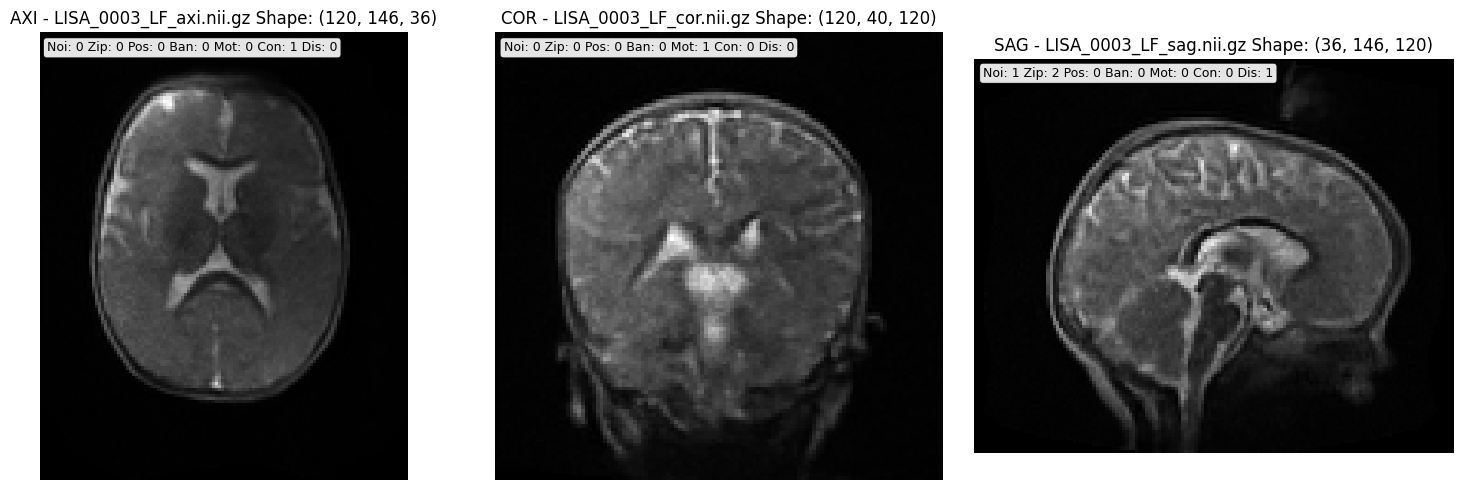

In [27]:
def load_and_visualize_sample(patient_id, slice_idx=None):
    """Load and visualize a sample patient's available orientations"""

    # First, check what orientations are available for this patient
    patient_files = df[df['patient_id'] == patient_id]

    if patient_files.empty:
        print(f"No files found for patient {patient_id}")
        return

    available_orientations = patient_files['orientation'].unique()
    print(f"Available orientations for {patient_id}: {list(available_orientations)}")

    # Create subplot based on available orientations
    num_orientations = len(available_orientations)
    fig, axes = plt.subplots(1, num_orientations, figsize=(5*num_orientations, 5))

    # Handle case where there's only one orientation
    if num_orientations == 1:
        axes = [axes]

    for i, orient in enumerate(available_orientations):
        filename = f'{patient_id}_LF_{orient}.nii.gz'
        filepath = data_dir / filename

        if filepath.exists():
            try:
                # Load image
                img = nib.load(filepath)
                data = img.get_fdata()

                # Get middle slice if not specified
                if slice_idx is None:
                    slice_idx = data.shape[2] // 2

                # Display slice (handle different orientations properly)
                if orient == 'axi':
                    slice_data = data[:, :, slice_idx]
                elif orient == 'cor':
                    slice_data = data[:, slice_idx, :]
                elif orient == 'sag':
                    slice_data = data[slice_idx, :, :]
                else:
                    slice_data = data[:, :, slice_idx]  # default

                #rotate the image by 90 degrees
                slice_data = np.rot90(slice_data, k=1)

                axes[i].imshow(slice_data, cmap='gray')
                axes[i].set_title(f'{orient.upper()} - {filename} Shape: {data.shape}')
                axes[i].axis('off')

                # Get quality scores for this image
                img_row = df[df['filename'] == filename]
                if not img_row.empty:
                    scores = img_row[artifact_categories].iloc[0]
                    # Format scores more compactly
                    score_pairs = [f'{cat[:3]}: {score}' for cat, score in scores.items()]
                    score_text = ' '.join(score_pairs)
                    axes[i].text(0.02, 0.98, score_text, transform=axes[i].transAxes,
                               fontsize=9, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error loading {filename}: {str(e)}',
                            transform=axes[i].transAxes, ha='center', va='center')
                axes[i].set_title(f'{orient.upper()} - ERROR')
        else:
            axes[i].text(0.5, 0.5, f'File not found: {filename}',
                        transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title(f'{orient.upper()} - NOT FOUND')

    plt.tight_layout()
    plt.show()

def find_patients_with_all_orientations():
    """Find patients that have all three orientations available"""
    patients_with_all = []
    patients_with_some = []

    for patient_id in df['patient_id'].unique():
        patient_files = df[df['patient_id'] == patient_id]
        orientations = set(patient_files['orientation'].unique())

        if len(orientations) == 3:  # Has all three orientations
            patients_with_all.append(patient_id)
        else:
            patients_with_some.append((patient_id, list(orientations)))

    return patients_with_all, patients_with_some

# Find better sample patients
patients_with_all, patients_with_some = find_patients_with_all_orientations()

print(f"Patients with all 3 orientations: {len(patients_with_all)}")
print(f"Patients with partial orientations: {len(patients_with_some)}")

if patients_with_all:
    print(f"First few patients with all orientations: {patients_with_all[:5]}")
    sample_patients = patients_with_all[:3]  # Take first 3 with all orientations
else:
    print("No patients have all 3 orientations. Using patients with available orientations:")
    sample_patients = ['LISA_0001', 'LISA_1001', 'LISA_2001']

# Visualize sample patients
for patient in sample_patients:
    print(f"{'='*60}")
    print(f"Patient: {patient}")
    print('='*60)
    load_and_visualize_sample(patient)

In [6]:
# Extract information from filenames
df['patient_id'] = df['filename'].str.extract(r'(LISA_\d+)_LF')
df['orientation'] = df['filename'].str.extract(r'LF_(\w+)\.nii\.gz')

# Check orientation distribution
orientation_counts = df['orientation'].value_counts()
print(f"Orientation distribution:")
for orient, count in orientation_counts.items():
    print(f"  {orient}: {count} images")

# Analyze patient distribution
print(f"\nPatient distribution analysis:")
patient_orientation_counts = df.groupby('patient_id')['orientation'].nunique().value_counts().sort_index()
print(f"Patients with 1 orientation: {patient_orientation_counts.get(1, 0)}")
print(f"Patients with 2 orientations: {patient_orientation_counts.get(2, 0)}")
print(f"Patients with 3 orientations: {patient_orientation_counts.get(3, 0)}")


# Find patients with interesting quality score patterns
print(f"\nFinding patients with diverse quality scores...")
patients_with_high_scores = []
patients_with_mixed_scores = []

# Define artifact categories
artifact_categories = ['Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']

for patient_id in df['patient_id'].unique():
    patient_data = df[df['patient_id'] == patient_id]
    max_scores = patient_data[artifact_categories].max()
    total_score = patient_data[artifact_categories].sum().sum()

    if max_scores.max() >= 2:  # Has at least one severe artifact
        patients_with_high_scores.append((patient_id, total_score))
    if total_score > 0 and total_score < 10:  # Has some artifacts but not too many
        patients_with_mixed_scores.append((patient_id, total_score))

# Sort by total score
patients_with_high_scores.sort(key=lambda x: x[1], reverse=True)
patients_with_mixed_scores.sort(key=lambda x: x[1], reverse=True)

print(f"Patients with severe artifacts (score=2): {len(patients_with_high_scores)}")
print(f"Patients with mixed quality scores: {len(patients_with_mixed_scores)}")

if patients_with_high_scores:
    print(f"Top patients with high artifact scores: {patients_with_high_scores[:5]}")
if patients_with_mixed_scores:
    print(f"Patients with mixed scores: {patients_with_mixed_scores[:5]}")

Orientation distribution:
  cor: 183 images
  sag: 176 images
  axi: 173 images

Patient distribution analysis:
Patients with 1 orientation: 100
Patients with 2 orientations: 0
Patients with 3 orientations: 144

Finding patients with diverse quality scores...
Patients with severe artifacts (score=2): 140
Patients with mixed quality scores: 221
Top patients with high artifact scores: [('LISA_0080', np.int64(14)), ('LISA_0083', np.int64(14)), ('LISA_0011', np.int64(13)), ('LISA_0069', np.int64(12)), ('LISA_0037', np.int64(11))]
Patients with mixed scores: [('LISA_0004', np.int64(9)), ('LISA_0064', np.int64(9)), ('LISA_1017', np.int64(9)), ('LISA_1001', np.int64(9)), ('LISA_1021', np.int64(9))]


In [7]:
def prepare_data_list(df, data_dir):
    """Prepare data list for MONAI DataLoader"""

    data_list = []

    for idx, row in df.iterrows():
        filename = row['filename']
        filepath = data_dir / filename

        if filepath.exists():
            # Extract orientation and encode as label
            orientation = row['orientation']
            orientation_mapping = {'axi': 0, 'cor': 1, 'sag': 2}

            # Get quality scores
            quality_scores = row[artifact_categories].values.astype(np.float32)

            data_item = {
                'image': str(filepath),
                'patient_id': row['patient_id'],
                'orientation': orientation_mapping[orientation],
                'filename': filename,
                'quality_scores': quality_scores,
                # Individual artifact scores
                'noise': row['Noise'],
                'zipper': row['Zipper'],
                'positioning': row['Positioning'],
                'banding': row['Banding'],
                'motion': row['Motion'],
                'contrast': row['Contrast'],
                'distortion': row['Distortion']
            }

            data_list.append(data_item)

    return data_list

# Prepare data list
data_list = prepare_data_list(df, data_dir)
print(f"Total samples prepared: {len(data_list)}")
print(f"Sample data item keys: {list(data_list[0].keys())}")

Total samples prepared: 532
Sample data item keys: ['image', 'patient_id', 'orientation', 'filename', 'quality_scores', 'noise', 'zipper', 'positioning', 'banding', 'motion', 'contrast', 'distortion']


In [8]:
# Split data by patient to avoid data leakage
# (images from same patient should not be in both train and test sets)

# Get unique patient IDs
unique_patients = df['patient_id'].unique()
print(f"Total unique patients: {len(unique_patients)}")

# Split patients into train/val/test
train_patients, temp_patients = train_test_split(
    unique_patients, test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

print(f"Train patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")
print(f"Test patients: {len(test_patients)}")

# Create data splits
train_data = [item for item in data_list if item['patient_id'] in train_patients]
val_data = [item for item in data_list if item['patient_id'] in val_patients]
test_data = [item for item in data_list if item['patient_id'] in test_patients]

print(f"Train images: {len(train_data)}")
print(f"Validation images: {len(val_data)}")
print(f"Test images: {len(test_data)}")

Total unique patients: 244
Train patients: 170
Validation patients: 37
Test patients: 37
Train images: 374
Validation images: 77
Test images: 81


In [9]:
# Define image processing transforms
img_size = (128, 128, 32)  # Resize to manageable size

# Base transforms (applied to all data)
base_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    ToTensord(keys=["image"])
])

# Training transforms (includes augmentation)
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    # Augmentations - using standard MONAI transforms
    RandRotated(keys=["image"], range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.3),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=0),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=1),
    RandZoomd(keys=["image"], min_zoom=0.9, max_zoom=1.1, prob=0.3),
    RandGaussianNoised(keys=["image"], std=0.01, prob=0.3),
    RandAdjustContrastd(keys=["image"], gamma=(0.8, 1.2), prob=0.3),
    ToTensord(keys=["image"])
])

# Validation/test transforms (no augmentation)
val_transforms = base_transforms

In [10]:
class RandRotateByAxisd(Transform):
    def __init__(self, keys, degrees=15, prob=0.5, keep_size=True):
        self.keys = keys
        self.degrees = degrees
        self.prob = prob
        self.keep_size = keep_size

    def __call__(self, data):
        if self.degrees == 0:
            return data

        # Check if orientation information is available
        orientation_key = None
        if "orientation" in data:
            orientation_key = "orientation"
        elif "label" in data:
            orientation_key = "label"
        else:
            # If no orientation info, apply random rotation
            range_x = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_y = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_z = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            rotation_transform = RandRotated(
                keys=self.keys,
                range_x=range_x,
                range_y=range_y,
                range_z=range_z,
                prob=self.prob,
                keep_size=self.keep_size,
            )
            return rotation_transform(data)

        orientation_value = data[orientation_key]

        # 2 == sag == x
        if (
            isinstance(orientation_value, np.ndarray)
            and orientation_value[-1] == 2
            or isinstance(orientation_value, (np.int64, int))
            and orientation_value == 2
        ):
            range_x = np.deg2rad(self.degrees)
            range_y = 0
            range_z = 0
        # 1 == cor == y
        elif (
            isinstance(orientation_value, np.ndarray)
            and orientation_value[-1] == 1
            or isinstance(orientation_value, (np.int64, int))
            and orientation_value == 1
        ):
            range_x = 0
            range_y = np.deg2rad(self.degrees)
            range_z = 0
        # 0 == axi == z
        elif (
            isinstance(orientation_value, np.ndarray)
            and orientation_value[-1] == 0
            or isinstance(orientation_value, (np.int64, int))
            and orientation_value == 0
        ):
            range_x = 0
            range_y = 0
            range_z = np.deg2rad(self.degrees)
        else:
            # Fallback to random rotation if orientation value is unexpected
            range_x = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_y = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_z = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)

        rotation_transform = RandRotated(
            keys=self.keys,
            range_x=range_x,
            range_y=range_y,
            range_z=range_z,
            prob=self.prob,
            keep_size=self.keep_size,
        )
        return rotation_transform(data)

In [11]:
# Define image processing transforms
img_size = (128, 128, 32)  # Resize to manageable size

# Base transforms (applied to all data)
base_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    ToTensord(keys=["image"])
])

# Training transforms (includes augmentation)
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    # Augmentations
    RandRotateByAxisd(keys=["image"], degrees=10, prob=0.3),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=0),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=1),
    RandZoomd(keys=["image"], min_zoom=0.9, max_zoom=1.1, prob=0.3),
    RandGaussianNoised(keys=["image"], std=0.01, prob=0.3),
    RandAdjustContrastd(keys=["image"], gamma=(0.8, 1.2), prob=0.3),
    ToTensord(keys=["image"])
])

# Validation/test transforms (no augmentation)
val_transforms = base_transforms

In [12]:
# Create datasets
train_dataset = Dataset(data=train_data, transform=train_transforms)
val_dataset = Dataset(data=val_data, transform=val_transforms)
test_dataset = Dataset(data=test_data, transform=val_transforms)

# Create data loaders
batch_size = 32
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 12
Validation batches: 3
Test batches: 3


## Training Base Models

### # A Reminder about Model Training

**Multi-Task Learning Strategy**

**Why Multi-Task Learning for Medical Images?**
- **Primary Task**: Quality assessment - predict artifact severity scores
- **Auxiliary Task**: Orientation prediction - helps model understand spatial structure
- **Shared Representations**: Common backbone learns features useful for both tasks
- **Regularization**: Auxiliary task prevents overfitting to quality assessment alone
- **Clinical Relevance**: Orientation awareness improves spatial understanding


**Loss Function Strategy:**
- **Artifact Loss**: Sum of CrossEntropyLoss for each of the 7 artifact types
- **Orientation Loss**: Single CrossEntropyLoss for 3-class orientation prediction
- **Combined Loss**: Weighted sum of both losses with adjustable balance

**Loss Weighting Philosophy:**
- **Primary Task Weight**: 1.0 (quality assessment is our main objective)
- **Auxiliary Task Weight**: 0.3 (orientation helps but shouldn't dominate)
- **Adaptive Weighting**: Could be adjusted based on validation performance

**Optimizer Configuration:**
- **Adam Optimizer**: Reliable for multi-task learning
- **Learning Rate**: 0.0001 (more conservative for complex model)
- **Weight Decay**: 1e-4 for regularization
- **Scheduler**: ReduceLROnPlateau for adaptive learning rate reduction

In [24]:
def calculate_multi_task_accuracy(artifact_outputs, orientation_output,
                                artifact_targets, orientation_targets):
    """
    Calculate accuracy for both tasks in multi-task learning.

    Returns:
        artifact_accuracy: Accuracy across all artifact predictions
        orientation_accuracy: Accuracy for orientation prediction
        combined_accuracy: Weighted combination of both accuracies
    """
    # Artifact accuracy (average across all 7 artifact types)
    artifact_correct = 0
    artifact_total = 0

    for i, output in enumerate(artifact_outputs):
        _, predicted = torch.max(output.data, 1)
        target = artifact_targets[:, i].long()
        artifact_total += target.size(0)
        artifact_correct += (predicted == target).sum().item()

    artifact_accuracy = artifact_correct / artifact_total

    # Orientation accuracy
    _, orientation_predicted = torch.max(orientation_output.data, 1)
    orientation_target = orientation_targets.long()
    orientation_correct = (orientation_predicted == orientation_target).sum().item()
    orientation_accuracy = orientation_correct / orientation_target.size(0)

    # Combined accuracy (weighted by task importance)
    combined_accuracy = (artifact_weight * artifact_accuracy +
                        orientation_weight * orientation_accuracy) / (artifact_weight + orientation_weight)

    return artifact_accuracy, orientation_accuracy, combined_accuracy

def train_epoch_multitask(model, train_loader, criterion, optimizer, device):
    """
    Train for one epoch with multi-task learning.
    """
    model.train()
    total_loss = 0
    total_artifact_accuracy = 0
    total_orientation_accuracy = 0
    total_combined_accuracy = 0

    for batch_idx, batch in enumerate(train_loader):
        images = batch['image'].to(device)
        artifact_targets = batch['quality_scores'].to(device)
        orientation_targets = batch['orientation'].to(device)

        optimizer.zero_grad()

        # Forward pass
        artifact_outputs, orientation_output = model(images)

        # Calculate losses
        artifact_loss = 0
        for i, output in enumerate(artifact_outputs):
            target = artifact_targets[:, i].long()
            artifact_loss += criterion(output, target)

        orientation_loss = criterion(orientation_output, orientation_targets.long())

        # Combined loss with weighting
        total_loss_batch = (artifact_weight * artifact_loss +
                           orientation_weight * orientation_loss)

        # Backward pass
        total_loss_batch.backward()
        optimizer.step()

        # Calculate accuracies
        artifact_acc, orientation_acc, combined_acc = calculate_multi_task_accuracy(
            artifact_outputs, orientation_output, artifact_targets, orientation_targets
        )

        total_loss += total_loss_batch.item()
        total_artifact_accuracy += artifact_acc
        total_orientation_accuracy += orientation_acc
        total_combined_accuracy += combined_acc

        if batch_idx % 5 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {total_loss_batch.item():.4f}, '
                  f'Artifact Acc: {artifact_acc:.3f}, '
                  f'Orient Acc: {orientation_acc:.3f}')

    return (total_loss / len(train_loader),
            total_artifact_accuracy / len(train_loader),
            total_orientation_accuracy / len(train_loader),
            total_combined_accuracy / len(train_loader))

def validate_epoch_multitask(model, val_loader, criterion, device):
    """
    Validate for one epoch with multi-task learning.
    """
    model.eval()
    total_loss = 0
    total_artifact_accuracy = 0
    total_orientation_accuracy = 0
    total_combined_accuracy = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            artifact_targets = batch['quality_scores'].to(device)
            orientation_targets = batch['orientation'].to(device)

            # Forward pass
            artifact_outputs, orientation_output = model(images)

            # Calculate losses
            artifact_loss = 0
            for i, output in enumerate(artifact_outputs):
                target = artifact_targets[:, i].long()
                artifact_loss += criterion(output, target)

            orientation_loss = criterion(orientation_output, orientation_targets.long())

            # Combined loss
            total_loss_batch = (artifact_weight * artifact_loss +
                               orientation_weight * orientation_loss)

            # Calculate accuracies
            artifact_acc, orientation_acc, combined_acc = calculate_multi_task_accuracy(
                artifact_outputs, orientation_output, artifact_targets, orientation_targets
            )

            total_loss += total_loss_batch.item()
            total_artifact_accuracy += artifact_acc
            total_orientation_accuracy += orientation_acc
            total_combined_accuracy += combined_acc

    return (total_loss / len(val_loader),
            total_artifact_accuracy / len(val_loader),
            total_orientation_accuracy / len(val_loader),
            total_combined_accuracy / len(val_loader))

def evaluate_multitask_model(model, test_loader, device):
  """
  Comprehensive evaluation of multi-task model on test set.

  Returns detailed metrics for both quality assessment and orientation prediction.
  """
  model.eval()

  # Storage for predictions and targets
  all_artifact_predictions = [[] for _ in range(7)]  # 7 artifact types
  all_artifact_targets = [[] for _ in range(7)]
  all_orientation_predictions = []
  all_orientation_targets = []

  # Additional info for analysis
  all_patient_ids = []
  all_filenames = []

  print("Evaluating model on test set...")

  with torch.no_grad():
      for batch_idx, batch in enumerate(test_loader):
          images = batch['image'].to(device)
          artifact_targets = batch['quality_scores'].to(device)
          orientation_targets = batch['orientation'].to(device)

          # Forward pass
          artifact_outputs, orientation_output = model(images)

          # Collect artifact predictions and targets
          for i, output in enumerate(artifact_outputs):
              _, predicted = torch.max(output, 1)
              all_artifact_predictions[i].extend(predicted.cpu().numpy())
              all_artifact_targets[i].extend(artifact_targets[:, i].cpu().numpy())

          # Collect orientation predictions and targets
          _, orientation_predicted = torch.max(orientation_output, 1)
          all_orientation_predictions.extend(orientation_predicted.cpu().numpy())
          all_orientation_targets.extend(orientation_targets.cpu().numpy())

          # Store additional info
          all_patient_ids.extend(batch['patient_id'])
          all_filenames.extend(batch['filename'])

          if batch_idx % 10 == 0:
              print(f"   Processed {batch_idx}/{len(test_loader)} batches")

  # Calculate comprehensive metrics
  results = {
      'artifact_results': {},
      'orientation_results': {},
      'patient_ids': all_patient_ids,
      'filenames': all_filenames
  }

  # Artifact evaluation (primary task)
  print("Calculating artifact assessment metrics...")
  for i, artifact_name in enumerate(artifact_names):
      y_true = np.array(all_artifact_targets[i])
      y_pred = np.array(all_artifact_predictions[i])

      # Calculate metrics
      f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
      f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
      f2_macro = fbeta_score(y_true, y_pred, average='macro', beta=2, zero_division=0)
      f2_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2, zero_division=0)

      accuracy = np.mean(y_true == y_pred)

      results['artifact_results'][artifact_name] = {
          'f1_macro': f1_macro,
          'f1_weighted': f1_weighted,
          'f2_macro': f2_macro,
          'f2_weighted': f2_weighted,
          'accuracy': accuracy,
          'predictions': y_pred,
          'targets': y_true
      }

  # Orientation evaluation (auxiliary task)
  print("Calculating orientation prediction metrics...")
  orientation_y_true = np.array(all_orientation_targets)
  orientation_y_pred = np.array(all_orientation_predictions)

  orientation_accuracy = np.mean(orientation_y_true == orientation_y_pred)
  orientation_f1 = f1_score(orientation_y_true, orientation_y_pred, average='macro', zero_division=0)

  results['orientation_results'] = {
      'accuracy': orientation_accuracy,
      'f1_macro': orientation_f1,
      'predictions': orientation_y_pred,
      'targets': orientation_y_true
  }

  return results

artifact_names = ['Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']


### DenseNet - Training and Testing

**Feature Extraction:**
- **DenseNet264**: 264-layer dense network with growth rate optimization
- **3D Convolutions**: Handle volumetric nature of MRI data
- **Adaptive Pooling**: Reduces spatial dimensions to single feature vector
- **Feature Dimension**: 2688-dimensional representation

**Classification Heads:**
- **Quality Scores**: 21 outputs (7 artifacts × 3 severity levels)
- **Orientation**: 3 outputs (axial, coronal, sagittal)
- **Separate Losses**: Independent optimization for each task

In [18]:
class AxisDenseNet264(nn.Module):
    """
    Multi-task DenseNet for MRI quality assessment and orientation prediction.

    This architecture combines:
    1. Quality assessment (primary task): Predicts artifact severity for 7 categories
    2. Orientation prediction (auxiliary task): Predicts scan orientation (axi/cor/sag)

    The multi-task approach helps the model learn better spatial representations
    by understanding both image content (quality) and spatial structure (orientation).
    """
    def __init__(self, spatial_dims=3, in_channels=1, out_channels=21):
        super(AxisDenseNet264, self).__init__()

        # Initialize MONAI's DenseNet264 as backbone
        self.base_model = nets.DenseNet264(
            spatial_dims=spatial_dims,    # 3D convolutions for volumetric data
            in_channels=in_channels,      # Single-channel MRI
            out_channels=out_channels,    # Will be modified below
        )

        # Replace the default classification layers with our custom pooling
        # This gives us access to the 2688-dimensional feature representation
        self.base_model.class_layers = nn.Sequential(
            nn.ReLU(inplace=True),                    # Non-linearity
            nn.AdaptiveAvgPool3d(output_size=1),      # Global average pooling
            nn.Flatten(start_dim=1, end_dim=-1),      # Flatten to vector
        )

        # Multi-label classification head for quality scores
        # 7 artifacts × 3 severity levels = 21 total classes
        # But we'll treat this as 7 separate 3-class problems
        self.artifact_heads = nn.ModuleList([
            nn.Linear(in_features=2688, out_features=3, bias=True)
            for _ in range(7)  # One head per artifact type
        ])

        # Auxiliary task: orientation classification
        # Helps model understand spatial structure
        self.orientation_head = nn.Linear(
            in_features=2688,
            out_features=3,   # axial, coronal, sagittal
            bias=True
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Returns:
            artifact_scores: List of 7 tensors, each (batch_size, 3) for artifact severity
            orientation_pred: Tensor (batch_size, 3) for orientation classification
        """
        # Extract features using DenseNet backbone
        features = self.base_model.features(x)      # Feature extraction
        features = self.base_model.class_layers(features)  # Pool and flatten

        # Multi-label artifact prediction (7 separate classifications)
        artifact_outputs = []
        for head in self.artifact_heads:
            artifact_outputs.append(head(features))

        # Orientation prediction (auxiliary task)
        orientation_output = self.orientation_head(features)

        return artifact_outputs, orientation_output

# Initialize the model
model_dense = AxisDenseNet264(
    spatial_dims=3,
    in_channels=1,
    out_channels=21  # This parameter is not used due to our custom heads
).to(device)

print(f"Model device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model_dense.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_dense.parameters() if p.requires_grad):,}")

# Test model with sample input
sample_input = torch.randn(2, 1, 128, 128, 64).to(device)
artifact_outputs, orientation_output = model_dense(sample_input)

print(f"Model Output Verification:")
print(f"Number of artifact heads: {len(artifact_outputs)}")
print(f"Each artifact head shape: {artifact_outputs[0].shape}")
print(f"Orientation output shape: {orientation_output.shape}")

# Verify the architecture makes sense
expected_artifact_shape = (2, 3)  # batch_size=2, 3 severity levels
expected_orientation_shape = (2, 3)  # batch_size=2, 3 orientations

assert all(output.shape == expected_artifact_shape for output in artifact_outputs), \
    "Artifact output shapes don't match expected dimensions"
assert orientation_output.shape == expected_orientation_shape, \
    "Orientation output shape doesn't match expected dimensions"

Model device: cuda
Total parameters: 40,310,424
Trainable parameters: 40,310,424
Model Output Verification:
Number of artifact heads: 7
Each artifact head shape: torch.Size([2, 3])
Orientation output shape: torch.Size([2, 3])


In [28]:
# Multi-task training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dense.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Training configuration
num_epochs = 25

# Loss weighting for multi-task learning
artifact_weight = 1.0      # Primary task
orientation_weight = 0.3   # Auxiliary task

# Tracking variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_artifact_accuracies = []
train_orientation_accuracies = []
val_artifact_accuracies = []
val_orientation_accuracies = []


print("Multi-task training setup complete!")
print(f"Artifact task weight: {artifact_weight}")
print(f"Orientation task weight: {orientation_weight}")
print(f"Total trainable parameters: {sum(p.numel() for p in model_dense.parameters() if p.requires_grad):,}")

Multi-task training setup complete!
Artifact task weight: 1.0
Orientation task weight: 0.3
Total trainable parameters: 40,310,424


In [14]:
# Multi-task training loop with comprehensive monitoring
best_combined_accuracy = 0
best_artifact_accuracy = 0
patience = 5
patience_counter = 0

print("Starting Multi-Task Training...")
print("=" * 60)
print(f"Architecture: MONAI DenseNet264 with {sum(p.numel() for p in model_dense.parameters()):,} parameters")
print(f"Primary Task: Quality Assessment (7 artifacts × 3 severity levels)")
print(f"Auxiliary Task: Orientation Prediction (3 orientations)")
print(f"Loss Weighting: Artifact={artifact_weight}, Orientation={orientation_weight}")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Training phase
    train_loss, train_artifact_acc, train_orientation_acc, train_combined_acc = train_epoch_multitask(
        model_dense, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_artifact_acc, val_orientation_acc, val_combined_acc = validate_epoch_multitask(
        model_dense, val_loader, criterion, device
    )

    # Update learning rate based on combined accuracy
    scheduler.step(val_combined_acc)
    current_lr = optimizer.param_groups[0]['lr']

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_artifact_accuracies.append(train_artifact_acc)
    train_orientation_accuracies.append(train_orientation_acc)
    val_artifact_accuracies.append(val_artifact_acc)
    val_orientation_accuracies.append(val_orientation_acc)
    train_accuracies.append(train_combined_acc)
    val_accuracies.append(val_combined_acc)

    # Print epoch summary
    print(f" Training   - Loss: {train_loss:.4f}, "
          f"Artifact: {train_artifact_acc:.3f}, "
          f"Orient: {train_orientation_acc:.3f}, "
          f"Combined: {train_combined_acc:.3f}")
    print(f" Validation - Loss: {val_loss:.4f}, "
          f"Artifact: {val_artifact_acc:.3f}, "
          f"Orient: {val_orientation_acc:.3f}, "
          f"Combined: {val_combined_acc:.3f}")
    print(f"  Learning Rate: {current_lr:.2e}")

    # Save best model based on combined accuracy
    if val_combined_acc > best_combined_accuracy:
        best_combined_accuracy = val_combined_acc
        best_artifact_accuracy = val_artifact_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_dense.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_combined_accuracy': best_combined_accuracy,
            'best_artifact_accuracy': best_artifact_accuracy,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_artifact_accuracies': train_artifact_accuracies,
            'val_artifact_accuracies': val_artifact_accuracies,
        }, 'best_multitask_model.pth')
        patience_counter = 0
        print(f" New best model saved! Combined Acc: {best_combined_accuracy:.4f}, "
              f"Artifact Acc: {best_artifact_accuracy:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        print(f"Best combined accuracy: {best_combined_accuracy:.4f}")
        print(f"Best artifact accuracy: {best_artifact_accuracy:.4f}")
        break

print(f"Training completed!")
print(f"Final Results:")
print(f"   Best Combined Accuracy: {best_combined_accuracy:.4f}")
print(f"   Best Artifact Accuracy: {best_artifact_accuracy:.4f}")
print(f"   Total Epochs: {len(train_losses)}")
print(f"   Final Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

Starting Multi-Task Training...
Architecture: MONAI DenseNet264 with 40,310,424 parameters
Primary Task: Quality Assessment (7 artifacts × 3 severity levels)
Auxiliary Task: Orientation Prediction (3 orientations)
Loss Weighting: Artifact=1.0, Orientation=0.3
Epoch 1/25
--------------------------------------------------
Batch 0/12, Loss: 8.1641, Artifact Acc: 0.281, Orient Acc: 0.406
Batch 5/12, Loss: 5.4399, Artifact Acc: 0.804, Orient Acc: 0.500
Batch 10/12, Loss: 4.2712, Artifact Acc: 0.812, Orient Acc: 0.562
 Training   - Loss: 5.6992, Artifact: 0.702, Orient: 0.469, Combined: 0.648
 Validation - Loss: 6.3696, Artifact: 0.693, Orient: 0.219, Combined: 0.584
  Learning Rate: 1.00e-04
 New best model saved! Combined Acc: 0.5838, Artifact Acc: 0.6933
Epoch 2/25
--------------------------------------------------
Batch 0/12, Loss: 4.2445, Artifact Acc: 0.795, Orient Acc: 0.469
Batch 5/12, Loss: 4.0015, Artifact Acc: 0.817, Orient Acc: 0.594
Batch 10/12, Loss: 3.2867, Artifact Acc: 0.848

In [35]:
# Load best model for evaluation
print("Loading best model for evaluation...")
checkpoint_dense = torch.load('best_multitask_model_dense.pth', map_location=device)
model_dense.load_state_dict(checkpoint_dense['model_state_dict'])
model_dense.eval()

print(f"Loaded model from epoch {checkpoint_dense['epoch']} with:")
print(f"   Combined accuracy: {checkpoint_dense['best_combined_accuracy']:.4f}")
print(f"   Artifact accuracy: {checkpoint_dense['best_artifact_accuracy']:.4f}")

# Evaluate on test set
test_results_dense = evaluate_multitask_model(model, test_loader, device)

# Print comprehensive results
print("="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

print(f"PRIMARY TASK: Quality Assessment Results")
print("-" * 70)
print(f"{'Artifact':<12} {'F1-Macro':<10} {'F1-Weighted':<12} {'F2-Macro':<10} {'F2-Weighted':<12} {'Accuracy':<10}")
print("-" * 70)

artifact_f1_scores_dense = []
for artifact_name in artifact_names:
    metrics = test_results_dense['artifact_results'][artifact_name]
    print(f"{artifact_name:<12} {metrics['f1_macro']:<10.4f} {metrics['f1_weighted']:<12.4f} "
          f"{metrics['f2_macro']:<10.4f} {metrics['f2_weighted']:<12.4f} {metrics['accuracy']:<10.4f}")
    artifact_f1_scores_dense.append((artifact_name, metrics['f1_macro']))

# Overall artifact metrics
overall_f1_macro_dense = np.mean([test_results_dense['artifact_results'][name]['f1_macro'] for name in artifact_names])
overall_f1_weighted_dense = np.mean([test_results_dense['artifact_results'][name]['f1_weighted'] for name in artifact_names])
overall_f2_macro_dense = np.mean([test_results_dense['artifact_results'][name]['f2_macro'] for name in artifact_names])
overall_f2_weighted_dense = np.mean([test_results_dense['artifact_results'][name]['f2_weighted'] for name in artifact_names])
overall_accuracy_dense = np.mean([test_results_dense['artifact_results'][name]['accuracy'] for name in artifact_names])

print("-" * 70)
print(f"{'OVERALL':<12} {overall_f1_macro_dense:<10.4f} {overall_f1_weighted_dense:<12.4f} "
      f"{overall_f2_macro_dense:<10.4f} {overall_f2_weighted_dense:<12.4f} {overall_accuracy_dense:<10.4f}")

print(f"AUXILIARY TASK: Orientation Prediction Results")
print("-" * 50)
orient_results_dense = test_results_dense['orientation_results']
print(f"Orientation Accuracy: {orient_results_dense['accuracy']:.4f}")
print(f"Orientation F1-Score: {orient_results_dense['f1_macro']:.4f}")

Loading best model for evaluation...
Loaded model from epoch 13 with:
   Combined accuracy: 0.7802
   Artifact accuracy: 0.7717
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
COMPREHENSIVE EVALUATION RESULTS
PRIMARY TASK: Quality Assessment Results
----------------------------------------------------------------------
Artifact     F1-Macro   F1-Weighted  F2-Macro   F2-Weighted  Accuracy  
----------------------------------------------------------------------
Noise        0.5129     0.7680       0.5602     0.7855       0.8025    
Zipper       0.5734     0.8075       0.6136     0.7954       0.7901    
Positioning  0.6163     0.8981       0.5721     0.9067       0.9136    
Banding      0.3270     0.9448       0.3308     0.9556       0.9630    
Motion       0.5183     0.7943       0.5168     0.8055       0.8148    
Contrast     0.5251     0.7069       0.5411     0.6966       0.6914    
Distor

### ResNet - Training and Testing

**Feature Extraction (ResNet18):**

* **ResNet18**: 18‑layer residual network using basic residual blocks for efficient feature reuse
* **3D Convolutions**: Volumetric extension via MONAI’s 3D ResNet18 backbone
* **Global Average Pooling**: Collapses spatial dimensions to a single 512‑dim vector before the head
* **Feature Dimension**: 512‑dimensional representation


In [18]:
from monai.networks.nets import resnet18

class AxisResNet50(nn.Module):
    """
    Multi-task ResNet50 for MRI quality assessment and orientation prediction.
    """
    def __init__(self, spatial_dims=3, in_channels=1):
        super(AxisResNet50, self).__init__()
        # note: we pass in_channels → n_input_channels, and use num_classes as placeholder
        self.backbone = resnet18(
        spatial_dims=spatial_dims,
        n_input_channels=in_channels,
        num_classes=1000,   # placeholder
        )
        self.backbone.fc = nn.Identity()
        feature_dim = 512  # ResNet‑18’s final feature size

        # seven 3‑class heads for artifact severity
        self.artifact_heads = nn.ModuleList([
            nn.Linear(feature_dim, 3, bias=True)
            for _ in range(7)
        ])
        # one 3‑class head for orientation
        self.orientation_head = nn.Linear(feature_dim, 3, bias=True)

    def forward(self, x):
        feats = self.backbone(x)  # → (B, 2048)
        artifact_outputs = [h(feats) for h in self.artifact_heads]
        orientation_output = self.orientation_head(feats)
        return artifact_outputs, orientation_output

# instantiate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = AxisResNet50(spatial_dims=3, in_channels=1).to(device)


print(f"Model device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model_resnet.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad):,}")

# Test model with sample input
sample_input = torch.randn(2, 1, 128, 128, 64).to(device)
artifact_outputs, orientation_output = model_resnet(sample_input)

print(f"Model Output Verification:")
print(f"Number of artifact heads: {len(artifact_outputs)}")
print(f"Each artifact head shape: {artifact_outputs[0].shape}")
print(f"Orientation output shape: {orientation_output.shape}")

# Verify the architecture makes sense
expected_artifact_shape = (2, 3)  # batch_size=2, 3 severity levels
expected_orientation_shape = (2, 3)  # batch_size=2, 3 orientations

assert all(output.shape == expected_artifact_shape for output in artifact_outputs), \
    "Artifact output shapes don't match expected dimensions"
assert orientation_output.shape == expected_orientation_shape, \
    "Orientation output shape doesn't match expected dimensions"

Model device: cuda
Total parameters: 33,173,208
Trainable parameters: 33,173,208
Model Output Verification:
Number of artifact heads: 7
Each artifact head shape: torch.Size([2, 3])
Orientation output shape: torch.Size([2, 3])


In [19]:
# Multi-task training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Training configuration
num_epochs = 25
artifact_names = ['Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']

# Loss weighting for multi-task learning
artifact_weight = 1.0      # Primary task
orientation_weight = 0.3   # Auxiliary task

# Tracking variables
train_losses_resnet = []
val_losses_resnet = []
train_accuracies_resnet = []
val_accuracies_resnet = []
train_artifact_accuracies_resnet = []
train_orientation_accuracies_resnet = []
val_artifact_accuracies_resnet = []
val_orientation_accuracies_resnet = []


# Multi-task training loop with comprehensive monitoring
best_combined_accuracy_resnet = 0
best_artifact_accuracy_resnet = 0
patience = 5
patience_counter = 0

print("Starting Multi-Task Training...")
print("=" * 60)
print(f"Architecture: MONAI ResNet with {sum(p.numel() for p in model_resnet.parameters()):,} parameters")
print(f"Primary Task: Quality Assessment (7 artifacts × 3 severity levels)")
print(f"Auxiliary Task: Orientation Prediction (3 orientations)")
print(f"Loss Weighting: Artifact={artifact_weight}, Orientation={orientation_weight}")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Training phase
    train_loss, train_artifact_acc, train_orientation_acc, train_combined_acc = train_epoch_multitask(
        model_resnet, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_artifact_acc, val_orientation_acc, val_combined_acc = validate_epoch_multitask(
        model_resnet, val_loader, criterion, device
    )

    # Update learning rate based on combined accuracy
    scheduler.step(val_combined_acc)
    current_lr = optimizer.param_groups[0]['lr']

    # Store metrics
    train_losses_resnet.append(train_loss)
    val_losses_resnet.append(val_loss)
    train_artifact_accuracies_resnet.append(train_artifact_acc)
    train_orientation_accuracies_resnet.append(train_orientation_acc)
    val_artifact_accuracies_resnet.append(val_artifact_acc)
    val_orientation_accuracies_resnet.append(val_orientation_acc)
    train_accuracies_resnet.append(train_combined_acc)
    val_accuracies_resnet.append(val_combined_acc)

    # Print epoch summary
    print(f" Training   - Loss: {train_loss:.4f}, "
          f"Artifact: {train_artifact_acc:.3f}, "
          f"Orient: {train_orientation_acc:.3f}, "
          f"Combined: {train_combined_acc:.3f}")
    print(f" Validation - Loss: {val_loss:.4f}, "
          f"Artifact: {val_artifact_acc:.3f}, "
          f"Orient: {val_orientation_acc:.3f}, "
          f"Combined: {val_combined_acc:.3f}")
    print(f"  Learning Rate: {current_lr:.2e}")

    # Save best model based on combined accuracy
    if val_combined_acc > best_combined_accuracy_resnet:
        best_combined_accuracy_resnet = val_combined_acc
        best_artifact_accuracy_resnet = val_artifact_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_combined_accuracy': best_combined_accuracy_resnet,
            'best_artifact_accuracy': best_artifact_accuracy_resnet,
            'train_losses': train_losses_resnet,
            'val_losses': val_losses_resnet,
            'train_artifact_accuracies': train_artifact_accuracies_resnet,
            'val_artifact_accuracies': val_artifact_accuracies_resnet,
        }, 'best_multitask_model.pth')
        patience_counter = 0
        print(f" New best model saved! Combined Acc: {best_combined_accuracy_resnet:.4f}, "
              f"Artifact Acc: {best_artifact_accuracy_resnet:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        print(f"Best combined accuracy: {best_combined_accuracy_resnet:.4f}")
        print(f"Best artifact accuracy: {best_artifact_accuracy_resnet:.4f}")
        break

print(f"Training completed!")
print(f"Final Results:")
print(f"   Best Combined Accuracy: {best_combined_accuracy_resnet:.4f}")
print(f"   Best Artifact Accuracy: {best_artifact_accuracy_resnet:.4f}")
print(f"   Total Epochs: {len(train_losses_resnet)}")
print(f"   Final Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")


Starting Multi-Task Training...
Architecture: MONAI ResNet with 33,173,208 parameters
Primary Task: Quality Assessment (7 artifacts × 3 severity levels)
Auxiliary Task: Orientation Prediction (3 orientations)
Loss Weighting: Artifact=1.0, Orientation=0.3
Epoch 1/25
--------------------------------------------------
Batch 0/12, Loss: 10.2050, Artifact Acc: 0.250, Orient Acc: 0.344
Batch 5/12, Loss: 5.3757, Artifact Acc: 0.808, Orient Acc: 0.188
Batch 10/12, Loss: 5.0889, Artifact Acc: 0.763, Orient Acc: 0.375
 Training   - Loss: 6.0943, Artifact: 0.666, Orient: 0.354, Combined: 0.594
 Validation - Loss: 5.7161, Artifact: 0.732, Orient: 0.270, Combined: 0.625
  Learning Rate: 1.00e-04
 New best model saved! Combined Acc: 0.6253, Artifact Acc: 0.7319
Epoch 2/25
--------------------------------------------------
Batch 0/12, Loss: 4.1698, Artifact Acc: 0.830, Orient Acc: 0.469
Batch 5/12, Loss: 4.3919, Artifact Acc: 0.795, Orient Acc: 0.406
Batch 10/12, Loss: 3.9422, Artifact Acc: 0.830, Or

In [26]:
# Load best model for evaluation
print("Loading best model for evaluation...")
checkpoint_resnet = torch.load('best_multitask_model_resnet.pth', map_location=device)
model_resnet.load_state_dict(checkpoint_resnet['model_state_dict'])
model_resnet.eval()

print(f"Loaded model from epoch {checkpoint_resnet['epoch']} with:")
print(f"   Combined accuracy: {checkpoint_resnet['best_combined_accuracy']:.4f}")
print(f"   Artifact accuracy: {checkpoint_resnet['best_artifact_accuracy']:.4f}")


# Evaluate on test set
test_results_resnet = evaluate_multitask_model(model_resnet, test_loader, device)

# Print comprehensive results
print("="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

print(f"PRIMARY TASK: Quality Assessment Results")
print("-" * 70)
print(f"{'Artifact':<12} {'F1-Macro':<10} {'F1-Weighted':<12} {'F2-Macro':<10} {'F2-Weighted':<12} {'Accuracy':<10}")
print("-" * 70)

artifact_f1_scores_resnet = []
for artifact_name in artifact_names:
    metrics = test_results_resnet['artifact_results'][artifact_name]
    print(f"{artifact_name:<12} {metrics['f1_macro']:<10.4f} {metrics['f1_weighted']:<12.4f} "
          f"{metrics['f2_macro']:<10.4f} {metrics['f2_weighted']:<12.4f} {metrics['accuracy']:<10.4f}")
    artifact_f1_scores_resnet.append((artifact_name, metrics['f1_macro']))

# Overall artifact metrics
overall_f1_macro_resnet = np.mean([test_results_resnet['artifact_results'][name]['f1_macro'] for name in artifact_names])
overall_f1_weighted_resnet = np.mean([test_results_resnet['artifact_results'][name]['f1_weighted'] for name in artifact_names])
overall_f2_macro_resnet = np.mean([test_results_resnet['artifact_results'][name]['f2_macro'] for name in artifact_names])
overall_f2_weighted_resnet = np.mean([test_results_resnet['artifact_results'][name]['f2_weighted'] for name in artifact_names])
overall_accuracy_resnet = np.mean([test_results_resnet['artifact_results'][name]['accuracy'] for name in artifact_names])

print("-" * 70)
print(f"{'OVERALL':<12} {overall_f1_macro_resnet:<10.4f} {overall_f1_weighted_resnet:<12.4f} "
      f"{overall_f2_macro_resnet:<10.4f} {overall_f2_weighted_resnet:<12.4f} {overall_accuracy_resnet:<10.4f}")

print(f"AUXILIARY TASK: Orientation Prediction Results")
print("-" * 50)
orient_results_resnet = test_results_resnet['orientation_results']
print(f"Orientation Accuracy: {orient_results_resnet['accuracy']:.4f}")
print(f"Orientation F1-Score: {orient_results_resnet['f1_macro']:.4f}")

Loading best model for evaluation...
Loaded model from epoch 23 with:
   Combined accuracy: 0.7592
   Artifact accuracy: 0.7555
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
COMPREHENSIVE EVALUATION RESULTS
PRIMARY TASK: Quality Assessment Results
----------------------------------------------------------------------
Artifact     F1-Macro   F1-Weighted  F2-Macro   F2-Weighted  Accuracy  
----------------------------------------------------------------------
Noise        0.5444     0.7919       0.5731     0.8196       0.8395    
Zipper       0.6021     0.8226       0.6548     0.8069       0.8025    
Positioning  0.4035     0.8842       0.3920     0.9009       0.9136    
Banding      0.5513     0.9672       0.5168     0.9718       0.9753    
Motion       0.4698     0.7635       0.4639     0.7704       0.7778    
Contrast     0.4380     0.7006       0.4329     0.7143       0.7284    
Distor

### EfficientNet - Training and Testing

**Feature Extraction (EfficientNet‑B0):**

* **EfficientNet‑B0**: Mobile inverted bottleneck blocks with squeeze‑and‑excitation and compound scaling
* **3D Convolutions**: Adapted to volumetric input via MONAI’s `EfficientNetBN`
* **Global Pooling**: Uses built‑in pooling after the backbone (head removed) to produce features
* **Feature Dimension**: 1280‑dimensional representation

In [44]:
from monai.networks.nets import EfficientNetBN

class AxisEfficientNetB0(nn.Module):
    """
    Multi‐task EfficientNet‑B0 for MRI quality assessment and orientation prediction.

    - Quality assessment (7 artifacts × 3 severity levels)
    - Orientation prediction (axial/coronal/sagittal)
    """
    def __init__(self, spatial_dims=3, in_channels=1):
        super(AxisEfficientNetB0, self).__init__()
        # 3D EfficientNet‑B0 backbone (drop the final fc layer so we get 1280‑dim features)
        self.backbone = EfficientNetBN(
            model_name="efficientnet-b0",
            pretrained=False,
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            num_classes=1000,   # placeholder, we override _fc
        )
        # remove the classification head
        self.backbone._fc = nn.Identity()
        feature_dim = 1280  # EfficientNet‑B0’s final feature size :contentReference[oaicite:0]{index=0}

        # Seven separate 3‑class heads for artifact severity
        self.artifact_heads = nn.ModuleList([
            nn.Linear(feature_dim, 3, bias=True)
            for _ in range(7)
        ])
        # One head for orientation (3 classes)
        self.orientation_head = nn.Linear(feature_dim, 3, bias=True)

    def forward(self, x):
        """
        Args:
            x: tensor of shape (B, C=1, D, H, W)
        Returns:
            artifact_outputs: list of 7 tensors, each (B, 3)
            orientation_output: tensor (B, 3)
        """
        feats = self.backbone(x)  # → (B, 1280)
        artifact_outputs = [head(feats) for head in self.artifact_heads]
        orientation_output = self.orientation_head(feats)
        return artifact_outputs, orientation_output

model_efficient = AxisEfficientNetB0(spatial_dims=3, in_channels=1).to(device)

print(f"Model device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model_efficient.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_efficient.parameters() if p.requires_grad):,}")

# Test model with sample input
sample_input = torch.randn(2, 1, 128, 128, 64).to(device)
artifact_outputs, orientation_output = model_efficient(sample_input)

print(f"Model Output Verification:")
print(f"Number of artifact heads: {len(artifact_outputs)}")
print(f"Each artifact head shape: {artifact_outputs[0].shape}")
print(f"Orientation output shape: {orientation_output.shape}")

# Verify the architecture makes sense
expected_artifact_shape = (2, 3)  # batch_size=2, 3 severity levels
expected_orientation_shape = (2, 3)  # batch_size=2, 3 orientations

assert all(output.shape == expected_artifact_shape for output in artifact_outputs), \
    "Artifact output shapes don't match expected dimensions"
assert orientation_output.shape == expected_orientation_shape, \
    "Orientation output shape doesn't match expected dimensions"


Model device: cuda
Total parameters: 4,719,124
Trainable parameters: 4,719,124
Model Output Verification:
Number of artifact heads: 7
Each artifact head shape: torch.Size([2, 3])
Orientation output shape: torch.Size([2, 3])


In [ ]:
# Multi-task training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficient.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Training configuration
num_epochs = 25
artifact_names = ['Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']

# Loss weighting for multi-task learning
artifact_weight = 1.0      # Primary task
orientation_weight = 0.3   # Auxiliary task

# Tracking variables
train_losses_efficient = []
val_losses_efficient = []
train_accuracies_efficient = []
val_accuracies_efficient = []
train_artifact_accuracies_efficient = []
train_orientation_accuracies_efficient = []
val_artifact_accuracies_efficient = []
val_orientation_accuracies_efficient = []


# Multi-task training loop with comprehensive monitoring
best_combined_accuracy_efficient = 0
best_artifact_accuracy_efficient = 0
patience = 5
patience_counter = 0

print("Starting Multi-Task Training...")
print("=" * 60)
print(f"Architecture: MONAI EfficientNet with {sum(p.numel() for p in model_efficient.parameters()):,} parameters")
print(f"Primary Task: Quality Assessment (7 artifacts × 3 severity levels)")
print(f"Auxiliary Task: Orientation Prediction (3 orientations)")
print(f"Loss Weighting: Artifact={artifact_weight}, Orientation={orientation_weight}")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Training phase
    train_loss, train_artifact_acc, train_orientation_acc, train_combined_acc = train_epoch_multitask(
        model_efficient, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_artifact_acc, val_orientation_acc, val_combined_acc = validate_epoch_multitask(
        model_efficient, val_loader, criterion, device
    )

    # Update learning rate based on combined accuracy
    scheduler.step(val_combined_acc)
    current_lr = optimizer.param_groups[0]['lr']

    # Store metrics
    train_losses_efficient.append(train_loss)
    val_losses_efficient.append(val_loss)
    train_artifact_accuracies_efficient.append(train_artifact_acc)
    train_orientation_accuracies_efficient.append(train_orientation_acc)
    val_artifact_accuracies_efficient.append(val_artifact_acc)
    val_orientation_accuracies_efficient.append(val_orientation_acc)
    train_accuracies_efficient.append(train_combined_acc)
    val_accuracies_efficient.append(val_combined_acc)

    # Print epoch summary
    print(f" Training   - Loss: {train_loss:.4f}, "
          f"Artifact: {train_artifact_acc:.3f}, "
          f"Orient: {train_orientation_acc:.3f}, "
          f"Combined: {train_combined_acc:.3f}")
    print(f" Validation - Loss: {val_loss:.4f}, "
          f"Artifact: {val_artifact_acc:.3f}, "
          f"Orient: {val_orientation_acc:.3f}, "
          f"Combined: {val_combined_acc:.3f}")
    print(f"  Learning Rate: {current_lr:.2e}")

    # Save best model based on combined accuracy
    if val_combined_acc > best_combined_accuracy_efficient:
        best_combined_accuracy_efficient = val_combined_acc
        best_artifact_accuracy_efficient = val_artifact_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_efficient.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_combined_accuracy': best_combined_accuracy_efficient,
            'best_artifact_accuracy': best_artifact_accuracy_efficient,
            'train_losses': train_losses_efficient,
            'val_losses': val_losses_efficient,
            'train_artifact_accuracies': train_artifact_accuracies_efficient,
            'val_artifact_accuracies': val_artifact_accuracies_efficient,
        }, 'best_multitask_model_efficient.pth')
        patience_counter = 0
        print(f" New best model saved! Combined Acc: {best_combined_accuracy_efficient:.4f}, "
              f"Artifact Acc: {best_artifact_accuracy_efficient:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        print(f"Best combined accuracy: {best_combined_accuracy_efficient:.4f}")
        print(f"Best artifact accuracy: {best_artifact_accuracy_efficient:.4f}")
        break

print(f"Training completed!")
print(f"Final Results:")
print(f"   Best Combined Accuracy: {best_combined_accuracy_efficient:.4f}")
print(f"   Best Artifact Accuracy: {best_artifact_accuracy_efficient:.4f}")
print(f"   Total Epochs: {len(train_losses_efficient)}")
print(f"   Final Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")


In [45]:
# Load best model for evaluation
print("Loading best model for evaluation...")
checkpoint_efficient = torch.load('best_multitask_model_efficient-2.pth', map_location=device)
model_efficient.load_state_dict(checkpoint_efficient['model_state_dict'])
model_efficient.eval()

print(f"Loaded model from epoch {checkpoint_efficient['epoch']} with:")
print(f"   Combined accuracy: {checkpoint_efficient['best_combined_accuracy']:.4f}")
print(f"   Artifact accuracy: {checkpoint_efficient['best_artifact_accuracy']:.4f}")


# Evaluate on test set
test_results_efficient = evaluate_multitask_model(model_efficient, test_loader, device)

# Print comprehensive results
print("="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

print(f"PRIMARY TASK: Quality Assessment Results")
print("-" * 70)
print(f"{'Artifact':<12} {'F1-Macro':<10} {'F1-Weighted':<12} {'F2-Macro':<10} {'F2-Weighted':<12} {'Accuracy':<10}")
print("-" * 70)

artifact_f1_scores_efficient = []
for artifact_name in artifact_names:
    metrics = test_results_efficient['artifact_results'][artifact_name]
    print(f"{artifact_name:<12} {metrics['f1_macro']:<10.4f} {metrics['f1_weighted']:<12.4f} "
          f"{metrics['f2_macro']:<10.4f} {metrics['f2_weighted']:<12.4f} {metrics['accuracy']:<10.4f}")
    artifact_f1_scores_efficient.append((artifact_name, metrics['f1_macro']))

# Overall artifact metrics
overall_f1_macro_efficient = np.mean([test_results_efficient['artifact_results'][name]['f1_macro'] for name in artifact_names])
overall_f1_weighted_efficient = np.mean([test_results_efficient['artifact_results'][name]['f1_weighted'] for name in artifact_names])
overall_f2_macro_efficient = np.mean([test_results_efficient['artifact_results'][name]['f2_macro'] for name in artifact_names])
overall_f2_weighted_efficient = np.mean([test_results_efficient['artifact_results'][name]['f2_weighted'] for name in artifact_names])
overall_accuracy_efficient = np.mean([test_results_efficient['artifact_results'][name]['accuracy'] for name in artifact_names])

print("-" * 70)
print(f"{'OVERALL':<12} {overall_f1_macro_efficient:<10.4f} {overall_f1_weighted_efficient:<12.4f} "
      f"{overall_f2_macro_efficient:<10.4f} {overall_f2_weighted_efficient:<12.4f} {overall_accuracy_efficient:<10.4f}")

print(f"AUXILIARY TASK: Orientation Prediction Results")
print("-" * 50)
orient_results_efficient = test_results_efficient['orientation_results']
print(f"Orientation Accuracy: {orient_results_efficient['accuracy']:.4f}")
print(f"Orientation F1-Score: {orient_results_efficient['f1_macro']:.4f}")

Loading best model for evaluation...
Loaded model from epoch 2 with:
   Combined accuracy: 0.6573
   Artifact accuracy: 0.7319
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
COMPREHENSIVE EVALUATION RESULTS
PRIMARY TASK: Quality Assessment Results
----------------------------------------------------------------------
Artifact     F1-Macro   F1-Weighted  F2-Macro   F2-Weighted  Accuracy  
----------------------------------------------------------------------
Noise        0.2864     0.6470       0.3128     0.7067       0.7531    
Zipper       0.3043     0.7663       0.3211     0.8086       0.8395    
Positioning  0.3160     0.8544       0.3262     0.8819       0.9012    
Banding      0.3270     0.9448       0.3308     0.9556       0.9630    
Motion       0.2968     0.7145       0.3177     0.7648       0.8025    
Contrast     0.2667     0.5333       0.3030     0.6061       0.6667    
Distort

# Ensembling

**What is ensembling in machine learning?** <br>
Ensemble learning in machine learning combines the predictions of multiple models to create a more accurate and robust prediction than any single model could achieve alone

Imagine this scenario: You train a single neural network on hundreds of photos: some of fluffy Chihuahuas, some of swirled cupcakes. At first, it seems to work: you snap a Chihuahua, it says “dog,” you snap a vanilla swirl, it says “cupcake.” But one morning, a pup with pale fur sits beside a lemon cupcake under the same warm spotlight… and your model proclaims “cupcake”!

Digging into why: your network had secretly learned “bright yellow backdrop = cupcake” and “small rounded shape = dog,” rather than true dog‑ears or frosting swirls. It had latched onto quirks of your photo setup instead of the objects themselves.

Then you try ensembling. You train three different classifiers: one that’s seen images under soft lighting, one with heavy color jittering, and one built on a different architecture altogether. When you show them that tricky Chihuahua‑cupcake pair, two models vote “dog” and one votes “cupcake,” so the ensemble goes with “dog.” By blending their perspectives, the ensemble drowns out each model’s weird little shortcut and focuses on the real signal.

That’s the power of ensembling: by combining diverse learners, you guard against those bizarre mistakes!

![Ensembling](https://substackcdn.com/image/fetch/$s_!nJXp!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F98e88d99-dbf6-4ec4-ae3b-127fd151479f_2208x878.jpeg)

## Voting

A voting classifier is an ML model that gains experience by training on a collection of several models and forecasts an output based on the class with the highest likelihood of becoming the output. To forecast the output class based on the largest majority of votes, it averages the results of each classifier provided into the voting classifier.

There are primarily two different types of voting classifiers:

- Hard Voting: The predicted output class is a class with the highest majority of votes,.

- Soft Voting: The average probabilities of the classes determine which one will be the final prediction.

In our case, we will use soft voting using the three base learners we have developed above.

![Voting](https://files.codingninjas.in/article_images/the-voting-classifier-1-1639979194.jpg)

In [46]:

# 1) Paths to your three best‐checkpoint files
ckpt_paths = [
    'best_multitask_model_dense.pth',
    'best_multitask_model_resnet.pth',
    'best_multitask_model_efficient-2.pth',
]

all_artifact_preds_voting = []     # will be shape (3, 7, N)
all_orientation_preds_voting = []  # will be shape (3, N)
targets_artifact_voting = None
targets_orientation_voting = None

# 2) Loop over each checkpoint + collect
for ckpt in ckpt_paths:
    print(f"Loading {ckpt} …")
    checkpoint = torch.load(ckpt, map_location=device)
    if "resnet" in ckpt:
      model = model_resnet
    elif "efficient" in ckpt:
      model = model_efficient
    else:
      model = model_dense
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    results_voting = evaluate_multitask_model(model, test_loader, device)

    # stack up predictions
    art_preds = [ results_voting['artifact_results'][name]['predictions']
                  for name in artifact_names ]         # list of length 7, each shape (N,)
    ori_preds = results_voting['orientation_results']['predictions']  # shape (N,)

    all_artifact_preds_voting.append( np.stack(art_preds, axis=0) )   # (7, N)
    all_orientation_preds_voting.append( ori_preds )                 # (N,)

    # grab the targets once
    if targets_artifact_voting is None:
        targets_artifact_voting = [ results_voting['artifact_results'][name]['targets']
                             for name in artifact_names ]     # list of 7 arrays
        targets_orientation_voting = results_voting['orientation_results']['targets']  # array

# convert to arrays
all_artifact_preds_voting    = np.stack(all_artifact_preds_voting, axis=0)    # (3, 7, N)
all_orientation_preds_voting = np.stack(all_orientation_preds_voting, axis=0) # (3, N)

# 3) Majority voting
#   For each artifact i, for each sample j, pick the most common label among the 3 models
ensemble_artifact_preds_voting = []
for i in range(7):
    # mode over axis=0 gives shape (1, N), take [0]
    voted, _ = mode(all_artifact_preds_voting[:, i, :], axis=0, keepdims=False)
    ensemble_artifact_preds_voting.append(voted)

# orientation
voted_ori, _ = mode(all_orientation_preds_voting, axis=0, keepdims=False)
ensemble_orientation_preds = voted_ori

# 4) Recompute your metrics exactly as you already do:
ensemble_results_voting = {
    'artifact_results': {},
    'orientation_results': {}
}

print("="*80)
print("ENSEMBLE (VOTING) EVALUATION RESULTS")
print("="*80)

# Artifact (primary task)
print("PRIMARY TASK: Quality Assessment")
print("-"*70)
print(f"{'Artifact':<12} {'F1-Macro':<10} {'F1-Weighted':<12} "
      f"{'F2-Macro':<10} {'F2-Weighted':<12} {'Accuracy':<10}")
print("-"*70)

for i, artifact_name in enumerate(artifact_names):
    y_true = np.array(targets_artifact_voting[i])
    y_pred = np.array(ensemble_artifact_preds_voting[i])

    f1_macro    = f1_score(y_true, y_pred, average='macro',    zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f2_macro    = fbeta_score(y_true, y_pred, average='macro',    beta=2, zero_division=0)
    f2_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2, zero_division=0)
    accuracy    = np.mean(y_true == y_pred)

    ensemble_results_voting['artifact_results'][artifact_name] = {
        'f1_macro':    f1_macro,
        'f1_weighted': f1_weighted,
        'f2_macro':    f2_macro,
        'f2_weighted': f2_weighted,
        'accuracy':    accuracy
    }

    print(f"{artifact_name:<12} {f1_macro:<10.4f} {f1_weighted:<12.4f} "
          f"{f2_macro:<10.4f} {f2_weighted:<12.4f} {accuracy:<10.4f}")

# Overall artifact summaries
overall_voting = ensemble_results_voting['artifact_results']
overall_f1_macro_voting  = np.mean([m['f1_macro']    for m in overall_voting.values()])
overall_f1_weighted_voting = np.mean([m['f1_weighted'] for m in overall_voting.values()])
overall_f2_macro_voting = np.mean([m['f2_macro']    for m in overall_voting.values()])
overall_f2_weighted_voting = np.mean([m['f2_weighted'] for m in overall_voting.values()])
overall_acc_voting = np.mean([m['accuracy']    for m in overall_voting.values()])

print("-"*70)
print(f"{'Overall':<12} {overall_f1_macro_voting:<10.4f} {overall_f1_weighted_voting:<12.4f} "
      f"{overall_f2_macro_voting:<10.4f} {overall_f2_weighted_voting:<12.4f} {overall_acc_voting:<10.4f}")

# Orientation (auxiliary task)
print("\nSECONDARY TASK: Orientation Prediction")
print("-"*40)
y_true_ori_voting = np.array(targets_orientation_voting)
y_pred_ori_voting = np.array(ensemble_orientation_preds)

ori_acc_voting   = np.mean(y_true_ori_voting == y_pred_ori_voting)
ori_f1_voting    = f1_score(y_true_ori_voting, y_pred_ori_voting, average='macro', zero_division=0)

ensemble_results_voting['orientation_results'] = {
    'accuracy': ori_acc_voting,
    'f1_macro': ori_f1_voting
}

print(f"Accuracy: {ori_acc_voting:.4f}")
print(f"F1-Macro: {ori_f1_voting:.4f}")

# That’s it – you now have your “voted” predictions and can compare
# ensemble vs. each individual model with the same metric calls you already use.

Loading best_multitask_model_dense.pth …
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
Loading best_multitask_model_resnet.pth …
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
Loading best_multitask_model_efficient-2.pth …
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
ENSEMBLE (VOTING) EVALUATION RESULTS
PRIMARY TASK: Quality Assessment
----------------------------------------------------------------------
Artifact     F1-Macro   F1-Weighted  F2-Macro   F2-Weighted  Accuracy  
----------------------------------------------------------------------
Noise        0.5444     0.7919       0.5731     0.8196       0.8395    
Zipper       0.5612     0.8040       0.5949     0.7947       0.7901    
Posi

## Bagging

Bagging, or Bootstrap Aggregating, is a machine learning ensemble method that improves model accuracy and stability by training multiple models on different subsets of the training data and then aggregating their predictions. This approach helps to reduce variance and prevent overfitting, leading to better generalization on unseen data.


Bagging starts by creating multiple subsets of the training data using a technique called bootstrapping. This involves randomly sampling with replacement from the original dataset, meaning some data points might appear multiple times in a subset, while others might be excluded.

In our case, we will implement bagging on the DenseNet model built above. However, since we have not made different subsets of the training set, we have to train our model again.

![Bagging](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*a6hnuJ8WM37mLimHfMORmQ.png)

Image resource: [BaggingWeb](https://medium.com/@brijesh_soni/boost-your-machine-learning-models-with-bagging-a-powerful-ensemble-learning-technique-692bfc4d1a51)

In [ ]:
# ------------------------------------------------------------------
# 1) Define a BootstrapSampler for bagging
# ------------------------------------------------------------------
class BootstrapSampler(Sampler):
    """
    Samples with replacement from the dataset indices,
    drawing exactly n_samples per epoch (default = full dataset size).
    """
    def __init__(self, data_source, n_samples=None):
        self.data_source = data_source
        self.n = n_samples or len(data_source)
        self.indices = list(range(len(data_source)))

    def __iter__(self):
        # draw with replacement
        return iter(
            np.random.choice(self.indices, size=self.n, replace=True).tolist()
        )

    def __len__(self):
        return self.n

# ------------------------------------------------------------------
# 2) Bagging loop: train K independent models on bootstrap samples
# ------------------------------------------------------------------
K = 5  # number of bagged estimators
num_epochs = 15
patience = 5

for b in range(K):
    print(f"\n=== Bagging estimator {b+1}/{K} ===")

    # a) instantiate a fresh model, optimizer, scheduler, and metrics tracking
    model_b = AxisDenseNet264(spatial_dims=3, in_channels=1).to(device)
    optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    best_combined_accuracy = 0
    best_artifact_accuracy = 0
    patience_counter = 0

    # b) create a bootstrapped train_loader for this bag
    train_loader_b = DataLoader(
        train_dataset,
        sampler=BootstrapSampler(train_dataset),
        batch_size=16,
        num_workers=4
    )
    # reuse your existing val_loader
    val_loader_b = val_loader

    # c) epoch loop (same as before but using model_b & train_loader_b)
    for epoch in range(num_epochs):
        print(f"Estimator {b+1}, Epoch {epoch+1}/{num_epochs}")

        # -- training --
        train_loss, train_art_acc, train_ori_acc, train_comb_acc = train_epoch_multitask(
            model_b, train_loader_b, criterion, optimizer, device
        )
        # -- validation --
        val_loss, val_art_acc, val_ori_acc, val_comb_acc = validate_epoch_multitask(
            model_b, val_loader_b, criterion, device
        )

        scheduler.step(val_comb_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"  Train comb acc: {train_comb_acc:.3f} | Val comb acc: {val_comb_acc:.3f} | LR: {current_lr:.2e}")

        # -- save best bagged model checkpoint --
        if val_comb_acc > best_combined_accuracy:
            best_combined_accuracy = val_comb_acc
            best_artifact_accuracy = val_art_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model_b.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_combined_accuracy': best_combined_accuracy,
                'best_artifact_accuracy': best_artifact_accuracy,
            }, f'bag_model_{b}.pth')
            patience_counter = 0
            print(f"  ✓ New best for bag {b}: {best_combined_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  ⏳ Early stopping estimator {b} at epoch {epoch+1}")
                break

    print(f"Finished training bag {b}, best combined acc = {best_combined_accuracy:.4f}")


In [25]:
K = 5  # number of bagged models
ckpt_paths = [f"bag_model_{b}.pth" for b in range(K)]

# storage
all_art_preds = []  # will become (K, 7, N_test)
all_ori_preds = []  # will become (K, N_test)
targets_art = None
targets_ori = None

# 1) Collect each bag's predictions
for i, ckpt in enumerate(ckpt_paths):

    # load checkpoint
    cp = torch.load(ckpt, map_location=device)
    model_dense.load_state_dict(cp['model_state_dict'])
    model_dense.to(device).eval()
    print("Evaluating bag model {}".format(i))
    # evaluate
    res = evaluate_multitask_model(model_dense, test_loader, device)

    # artifact preds: list of 7 arrays shape (N_test,)
    art_list = [res['artifact_results'][name]['predictions'] for name in artifact_names]
    ori_arr  = res['orientation_results']['predictions']               # (N_test,)

    # stack
    all_art_preds.append(np.stack(art_list, axis=0))  # (7, N_test)
    all_ori_preds.append(ori_arr)                     # (N_test,)

    # grab targets once
    if targets_art is None:
        targets_art = [res['artifact_results'][name]['targets'] for name in artifact_names]
        targets_ori = res['orientation_results']['targets']

# to numpy arrays
all_art_preds = np.stack(all_art_preds, axis=0)  # (K, 7, N_test)
all_ori_preds = np.stack(all_ori_preds, axis=0)  # (K, N_test)

# 2) Majority‐vote aggregation
ensemble_art_preds = []
for i in range(7):
    voted, _ = mode(all_art_preds[:, i, :], axis=0, keepdims=False)
    ensemble_art_preds.append(voted)              # (N_test,)

voted_ori, _ = mode(all_ori_preds, axis=0, keepdims=False)
ensemble_ori_preds = voted_ori                   # (N_test,)

ensemble_results_bagging = {
    'artifact_results': {},
    'orientation_results': {}
}

# 3) Compute metrics
print("="*80)
print("BAGGED ENSEMBLE EVALUATION RESULTS")
print("="*80)
print("PRIMARY TASK: Quality Assessment")
print("-"*70)
print(f"{'Artifact':<12} {'F1-Macro':<10} {'F1-Weighted':<12} "
      f"{'F2-Macro':<10} {'F2-Weighted':<12} {'Accuracy':<10}")
print("-"*70)

for i, name in enumerate(artifact_names):
    y_true = np.array(targets_art[i])
    y_pred = np.array(ensemble_art_preds[i])

    f1_macro    = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f2_macro    = fbeta_score(y_true, y_pred, average='macro', beta=2, zero_division=0)
    f2_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2, zero_division=0)
    accuracy    = np.mean(y_true == y_pred)

    ensemble_results_bagging['artifact_results'][name] = {
        'f1_macro':    f1_macro,
        'f1_weighted': f1_weighted,
        'f2_macro':    f2_macro,
        'f2_weighted': f2_weighted,
        'accuracy':    accuracy
    }
    print(f"{name:<12} {f1_macro:<10.4f} {f1_weighted:<12.4f} "
          f"{f2_macro:<10.4f} {f2_weighted:<12.4f} {accuracy:<10.4f}")


# overall artifact
overall_bagging = ensemble_results_bagging['artifact_results']
overall_f1_macro_bagging  = np.mean([m['f1_macro']    for m in overall_bagging.values()])
overall_f1_weighted_bagging = np.mean([m['f1_weighted'] for m in overall_bagging.values()])
overall_f2_macro_bagging = np.mean([m['f2_macro']    for m in overall_bagging.values()])
overall_f2_weighted_bagging = np.mean([m['f2_weighted'] for m in overall_bagging.values()])
overall_acc_bagging = np.mean([m['accuracy']    for m in overall_bagging.values()])

print("-"*70)
print(f"{'Overall':<12} {overall_f1_macro_bagging:<10.4f} {overall_f1_weighted_bagging:<12.4f} "
      f"{overall_f2_macro_bagging:<10.4f} {overall_f2_weighted_bagging:<12.4f} {overall_acc_bagging:<10.4f}")

print("\nSECONDARY TASK: Orientation Prediction")
print("-"*40)
y_true_ori_bagging = np.array(targets_ori)
y_pred_ori_bagging = np.array(ensemble_ori_preds)
ori_acc_bagging   = np.mean(y_true_ori_bagging == y_pred_ori_bagging)
ori_f1_bagging    = f1_score(y_true_ori_bagging, y_pred_ori_bagging, average='macro', zero_division=0)

ensemble_results_bagging['orientation_results'] = {
    'accuracy': ori_acc_bagging,
    'f1_macro': ori_f1_bagging
}
print(f"Accuracy: {ori_acc_bagging:.4f}")
print(f"F1-Macro: {ori_f1_bagging:.4f}")


Evaluating bag model 0
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
Evaluating bag model 1
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
Evaluating bag model 2
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
Evaluating bag model 3
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
Evaluating bag model 4
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
BAGGED ENSEMBLE EVALUATION RESULTS
PRIMARY TASK: Quality Assessment
----------------------------------------------------------------------
Artifact     F1-

## Stacking

Stacking is a technique that boosts AI capabilities by combining multiple machine learning models into one system. It works by taking the predictions from each model and feeding them into a final "meta-model" that learns how to best blend and stack their strengths.

This meta-learner could be any simple classifier. In our case, we will use logistic regression as our meta-learner, and we will use the three base models (ResNet, DenseNet, and EfficientNet) as our base learners.

![Stacking](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*DM1DhgvG3UCEZTF-Ev5Q-A.png)

Image resource: [StackingWeb](https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28)

In [47]:
ckpt_paths = [
    "best_multitask_model_dense.pth",
    "best_multitask_model_resnet.pth",
    "best_multitask_model_efficient.pth",
]


# ── 2) Helper: get soft‑probs + true labels on val set ────────────────────────
def collect_probas_and_labels(model, loader):
    model.eval()
    art_probs = [[] for _ in range(7)]
    ori_probs = []
    art_targets = [[] for _ in range(7)]
    ori_targets = []

    with torch.no_grad():
        for batch in loader:
            x = batch["image"].to(device)
            y_art = batch["quality_scores"].numpy()      # (B,7)
            y_ori = batch["orientation"].numpy()         # (B,)

            art_outs, ori_out = model(x)
            # collect artifact softmax‑probs
            for i, out in enumerate(art_outs):
                p = torch.softmax(out, dim=1).cpu().numpy()  # (B,3)
                art_probs[i].append(p)
                art_targets[i].append(y_art[:, i])

            # collect orientation softmax‑probs
            p_o = torch.softmax(ori_out, dim=1).cpu().numpy()  # (B,3)
            ori_probs.append(p_o)
            ori_targets.append(y_ori)

    # concatenate across batches
    art_probs = [np.vstack(lst) for lst in art_probs]  # list of 7 arrays (N_val,3)
    art_targets = [np.hstack(lst) for lst in art_targets]  # list of 7 arrays (N_val,)
    ori_probs = np.vstack(ori_probs)      # (N_val,3)
    ori_targets = np.hstack(ori_targets)  # (N_val,)

    return art_probs, art_targets, ori_probs, ori_targets

# ── 3) Collect meta‑features from each base ──────────────────────────────────
all_art_meta = [ [] for _ in range(7) ]  # for each artifact: list of (N_val,3)
all_ori_meta = []                        # list of (N_val,3)
art_true = None
ori_true = None

for ckpt in ckpt_paths:
    # load checkpoint & model architecture
    checkpoint = torch.load(ckpt, map_location=device)
    if "resnet" in ckpt:
      model = model_resnet
    elif "efficient" in ckpt:
      model = model_efficient
    else:
      model = model_dense
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)

    art_p, art_t, ori_p, ori_t = collect_probas_and_labels(model, val_loader)

    # append each head’s probs
    for i in range(7):
        all_art_meta[i].append(art_p[i])
    all_ori_meta.append(ori_p)

    # capture true labels once
    if art_true is None:
        art_true = art_t
        ori_true = ori_t

# stack along “model” axis → for each head i, shape becomes (N_val, 3_models × 3)
art_meta_mats = [
    np.hstack(all_art_meta[i]) for i in range(7)
]
# orientation: (N_val, 3_models × 3)
ori_meta_mat = np.hstack(all_ori_meta)

# ── 4) Train meta‑learners ───────────────────────────────────────────────────
artifact_meta_models = {}
for i, name in enumerate(artifact_names):
    clf = LogisticRegression(multi_class="multinomial", max_iter=500)
    clf.fit(art_meta_mats[i], art_true[i])
    artifact_meta_models[name] = clf

orientation_meta_model = LogisticRegression(multi_class="multinomial", max_iter=500)
orientation_meta_model.fit(ori_meta_mat, ori_true)

print("✓ Meta‑learners trained on validation set outputs.")


✓ Meta‑learners trained on validation set outputs.


In [58]:
# 1) Collect test meta‑features
all_art_test = [[] for _ in range(7)]
all_ori_test = []

for ckpt in ckpt_paths:
    checkpoint = torch.load(ckpt, map_location=device)
    # pick the right model object
    model = (model_resnet if "resnet" in ckpt
             else model_efficient if "efficient" in ckpt
             else model_dense)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device).eval()

    art_p, art_targets_list, ori_p, ori_targets = collect_probas_and_labels(model, test_loader)

    for i in range(7):
        all_art_test[i].append(art_p[i])   # each is (N_test,3)
    all_ori_test.append(ori_p)            # list of (N_test,3)


test_targets_artifact = {
    name: art_targets_list[i]
    for i, name in enumerate(artifact_names)
}
test_targets_orientation = ori_targets

# Stack into matrices: (N_test, 3_models×3)
test_art_meta_mats = [ np.hstack(all_art_test[i]) for i in range(7) ]
test_ori_meta_mat  = np.hstack(all_ori_test)

# 2) Predict with meta‑learners
ensemble_art_preds = {}
for i, name in enumerate(artifact_names):
    clf = artifact_meta_models[name]
    ensemble_art_preds[name] = clf.predict(test_art_meta_mats[i])

ensemble_ori_preds = orientation_meta_model.predict(test_ori_meta_mat)

ensemble_results_stacking = {
    'artifact_results': {},
    'orientation_results': {}
}

print("="*80)
# 3) Compute metrics just like before
print("STACKED ENSEMBLE RESULTS ON TEST SET")
print("-"*80)

# Artifact (primary task)
print("PRIMARY TASK: Quality Assessment")
print("-"*70)
print(f"{'Artifact':<12} {'F1-Macro':<10} {'F1-Weighted':<12} "
      f"{'F2-Macro':<10} {'F2-Weighted':<12} {'Accuracy':<10}")
print("-"*70)

for artifact_name in artifact_names:
    y_true = np.array(test_targets_artifact[artifact_name])  # your test-ground-truth array
    y_pred = ensemble_art_preds[artifact_name]

    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f2_macro    = fbeta_score(y_true, y_pred, average='macro',    beta=2, zero_division=0)
    f2_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2, zero_division=0)
    accuracy = np.mean(y_true == y_pred)

    ensemble_results_stacking['artifact_results'][artifact_name] = {
        'f1_macro':    f1_macro,
        'f1_weighted': f1_weighted,
        'f2_macro':    f2_macro,
        'f2_weighted': f2_weighted,
        'accuracy':    accuracy
    }

    print(f"{artifact_name:<12} {f1_macro:<10.4f} {f1_weighted:<12.4f} "
          f"{f2_macro:<10.4f} {f2_weighted:<12.4f} {accuracy:<10.4f}")


# Overall artifact summaries
overall_stacking = ensemble_results_stacking['artifact_results']
overall_f1_macro_stacking  = np.mean([m['f1_macro']    for m in overall_stacking.values()])
overall_f1_weighted_stacking = np.mean([m['f1_weighted'] for m in overall_stacking.values()])
overall_f2_macro_stacking = np.mean([m['f2_macro']    for m in overall_stacking.values()])
overall_f2_weighted_stacking = np.mean([m['f2_weighted'] for m in overall_stacking.values()])
overall_acc_stacking = np.mean([m['accuracy']    for m in overall_stacking.values()])


print("-"*70)
print(f"{'Overall':<12} {overall_f1_macro_stacking:<10.4f} {overall_f1_weighted_stacking:<12.4f} "
      f"{overall_f2_macro_stacking:<10.4f} {overall_f2_weighted_stacking:<12.4f} {overall_acc_stacking:<10.4f}")

print("\nSECONDARY TASK: Orientation Prediction")
print("-"*40)

y_true_ori = np.array(test_targets_orientation)
f1_ori     = f1_score(y_true_ori, ensemble_ori_preds, average="macro", zero_division=0)
acc_ori    = np.mean(y_true_ori == ensemble_ori_preds)
ensemble_results_stacking['orientation_results'] = {
    'accuracy': acc_ori,
    'f1_macro': f1_ori
}

print(f"Accuracy: {acc_ori:.4f}")
print(f"F1-Macro: {f1_ori:.4f}")

STACKED ENSEMBLE RESULTS ON TEST SET
--------------------------------------------------------------------------------
PRIMARY TASK: Quality Assessment
----------------------------------------------------------------------
Artifact     F1-Macro   F1-Weighted  F2-Macro   F2-Weighted  Accuracy  
----------------------------------------------------------------------
Noise        0.5550     0.8005       0.5953     0.8298       0.8519    
Zipper       0.5933     0.8204       0.6386     0.8074       0.8025    
Positioning  0.3160     0.8544       0.3262     0.8819       0.9012    
Banding      0.3270     0.9448       0.3308     0.9556       0.9630    
Motion       0.4494     0.7691       0.4668     0.7887       0.8025    
Contrast     0.3510     0.6095       0.3582     0.6452       0.6790    
Distortion   0.3043     0.7663       0.3211     0.8086       0.8395    
----------------------------------------------------------------------
Overall      0.4137     0.7950       0.4339     0.8167      